In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

a_coeff = 1 # 2 1 1
b_coeff = 1 # 1 2 1
mu_coeff = 1  # 1 1 2
f = lambda x, y, t: np.sin(x) * np.sin(y) * (mu_coeff * np.cos(mu_coeff * t) + (a_coeff + b_coeff) * np.sin(mu_coeff * t))

alpha1 = 0
beta1 = 1
gamma1 = lambda y, t: 0

alpha2 = 0
beta2 = 1
gamma2 = lambda y, t: np.sin(y) * np.sin(mu_coeff * t)

alpha3 = 0
beta3 = 1
gamma3 = lambda x, t: 0

alpha4 = 1
beta4 = 0
gamma4 = lambda x, t: -np.sin(x) * np.sin(mu_coeff * t)

psi = lambda x, y: 0

analytical_solution = lambda x, y, t: np.sin(x) * np.sin(y) * np.sin(mu_coeff * t)

Lx = np.pi / 2
Ly = np.pi
T_max = 10


In [50]:
def solve_alternating_directions():
    u_num = np.zeros((len(X), len(Y), len(T)))

    # u_num[:, :, 0] = psi(X, Y) 
    for i in range(len(X)):
        for j in range(len(Y)):
            u_num[i, j, 0] = psi(X[i], Y[j])
    

    N = len(X) - 1
    M = len(Y) - 1

    for k in range(0, len(T) - 1, 2):
        u_prev = u_num[:, :, k]
        u_next = np.zeros_like(u_prev)
        
        for j in range(1, M):
            
            A = np.zeros(len(X))
            B = np.zeros(len(X))
            C = np.zeros(len(X))
            D = np.zeros(len(X))
            
            for i in range(1, N):
                A[i] = -a_coeff / hx ** 2
                B[i] = 2 / tau + 2 * a_coeff / hx ** 2
                C[i] = -a_coeff / hx ** 2
                D[i] = f(X[i], Y[j], T[k + 1]) + b_coeff / hy ** 2 * (
                    u_prev[i, j + 1] - 2 * u_prev[i, j] + u_prev[i, j - 1]
                ) + 2 * u_prev[i, j] / tau
            
            coeff1 = (-alpha1 / 2 / hx) / C[1]
            A[0] = 0
            B[0] = (alpha1 * (-3 /(2 * hx)) + beta1) - A[1] * coeff1
            C[0] = (alpha1 * (4 /(2 * hx))) - B[1] * coeff1
            D[0] = gamma1(Y[j], T[k + 1]) - D[1] * coeff1
            
            coeff2 = (alpha2 / 2 / hx) / A[N - 1]
            A[N] = -alpha2 * (4 / (2 * hx)) - B[N - 1] * coeff2
            B[N] = alpha2 * (3 / (2 * hx)) + beta2 - C[N - 1] * coeff2
            C[N] = 0
            D[N] = gamma2(Y[j], T[k + 1]) - D[N - 1] * coeff2
            
            alpha_prop = np.zeros(N + 1)
            beta_prop = np.zeros(N + 1)
            
            if abs(B[0]) < 1e-12:
                raise ValueError("Деление на ноль в методе прогонки")
           
            alpha_prop[0] = -C[0] / B[0]
            beta_prop[0] = D[0] / B[0]

            for i in range(1, N + 1):
                denominator = B[i] + A[i] * alpha_prop[i - 1]
                if abs(denominator) < 1e-12:
                    raise ValueError("Деление на ноль в методе прогонки")
                if i < N:
                    alpha_prop[i] = -C[i] / denominator
                beta_prop[i] = (D[i] - A[i] * beta_prop[i - 1]) / denominator

            u_next[N, j] = beta_prop[N]
            
            for i in range(N - 1, -1, -1):
                u_next[i, j] = alpha_prop[i] * u_next[i + 1, j] + beta_prop[i]

        u_next[:, 0] = (gamma3(X, T[k + 1]) - 
                        u_next[:, 1] * (2 * alpha3 / hy) -
                        u_next[:, 2] * (-alpha3 / 2 / hy)) / \
                        (-3 * alpha3 / 2 / hy + beta3)
        u_next[:, M] = (gamma4(X, T[k + 1]) - 
                        u_next[:, M - 1] * (-2 * alpha4 / hy) -
                        u_next[:, M - 2] * (alpha4 / 2 / hy)) / \
                        (3 * alpha4 / 2 / hy + beta4)            
        
            
        u_num[:, :, k + 1] = u_next
            
        u_prev = u_num[:, :, k + 1]
        u_next = np.zeros_like(u_prev)
        
        for i in range(1, N):
            A = np.zeros(len(Y))
            B = np.zeros(len(Y))
            C = np.zeros(len(Y))
            D = np.zeros(len(Y))
            
            for j in range(1, M):
                A[j] = -b_coeff / hy ** 2
                B[j] = 2 / tau + 2 * b_coeff / hy ** 2
                C[j] = -b_coeff / hy ** 2
                D[j] = f(X[i], Y[j], T[k + 1]) + a_coeff / hx ** 2 * (
                    u_prev[i + 1, j] - 2 * u_prev[i, j] + u_prev[i - 1, j]
                ) + 2 * u_prev[i, j] / tau
            
            
            coeff3 = (-alpha3 / 2 / hy) / C[1]
            A[0] = 0
            B[0] = (alpha3 * (-3 /(2 * hy)) + beta3) - A[1] * coeff3
            C[0] = (alpha3 * (4 /(2 * hy))) - B[1] * coeff3
            D[0] = gamma3(X[i], T[k + 2]) - D[1] * coeff3
            
            coeff4 = (alpha4 / 2 / hy) / A[M - 1]
            A[M] = -alpha4 * (4 / (2 * hy)) - B[M - 1] * coeff4
            B[M] = alpha4 * (3 / (2 * hy)) + beta4 - C[M - 1] * coeff4
            C[M] = 0
            D[M] = gamma4(X[i], T[k + 2]) - D[M - 1] * coeff4
            
            
            alpha_prop = np.zeros(M + 1)
            beta_prop = np.zeros(M + 1)
            
            if abs(B[0]) < 1e-12:
                raise ValueError("Деление на ноль в методе прогонки")
           
            alpha_prop[0] = -C[0] / B[0]
            beta_prop[0] = D[0] / B[0]

            for j in range(1, M + 1):
                denominator = B[j] + A[j] * alpha_prop[j - 1]
                if abs(denominator) < 1e-12:
                    raise ValueError("Деление на ноль в методе прогонки")
                if j < M:
                    alpha_prop[j] = -C[j] / denominator
                beta_prop[j] = (D[j] - A[j] * beta_prop[j - 1]) / denominator

            u_next[i, M] = beta_prop[M]
            
            for j in range(M - 1, -1, -1):
                u_next[i, j] = alpha_prop[j] * u_next[i, j + 1] + beta_prop[j]
       
        u_next[0, :] = (gamma1(Y, T[k + 2]) - 
                        u_next[1, :] * (2 * alpha1 / hx) -
                        u_next[2, :] * (-alpha1 / 2 / hx)) / \
                        (-3 * alpha1 / 2 / hx + beta1)
        u_next[N, :] = (gamma2(Y, T[k + 2]) - 
                        u_next[N - 1, :] * (-2 * alpha2 / hx) -
                        u_next[N - 2, :] * (alpha2 / 2 / hx)) / \
                        (3 * alpha2 / 2 / hx + beta2)     

        u_num[:, :, k + 2] = u_next
        
    return u_num

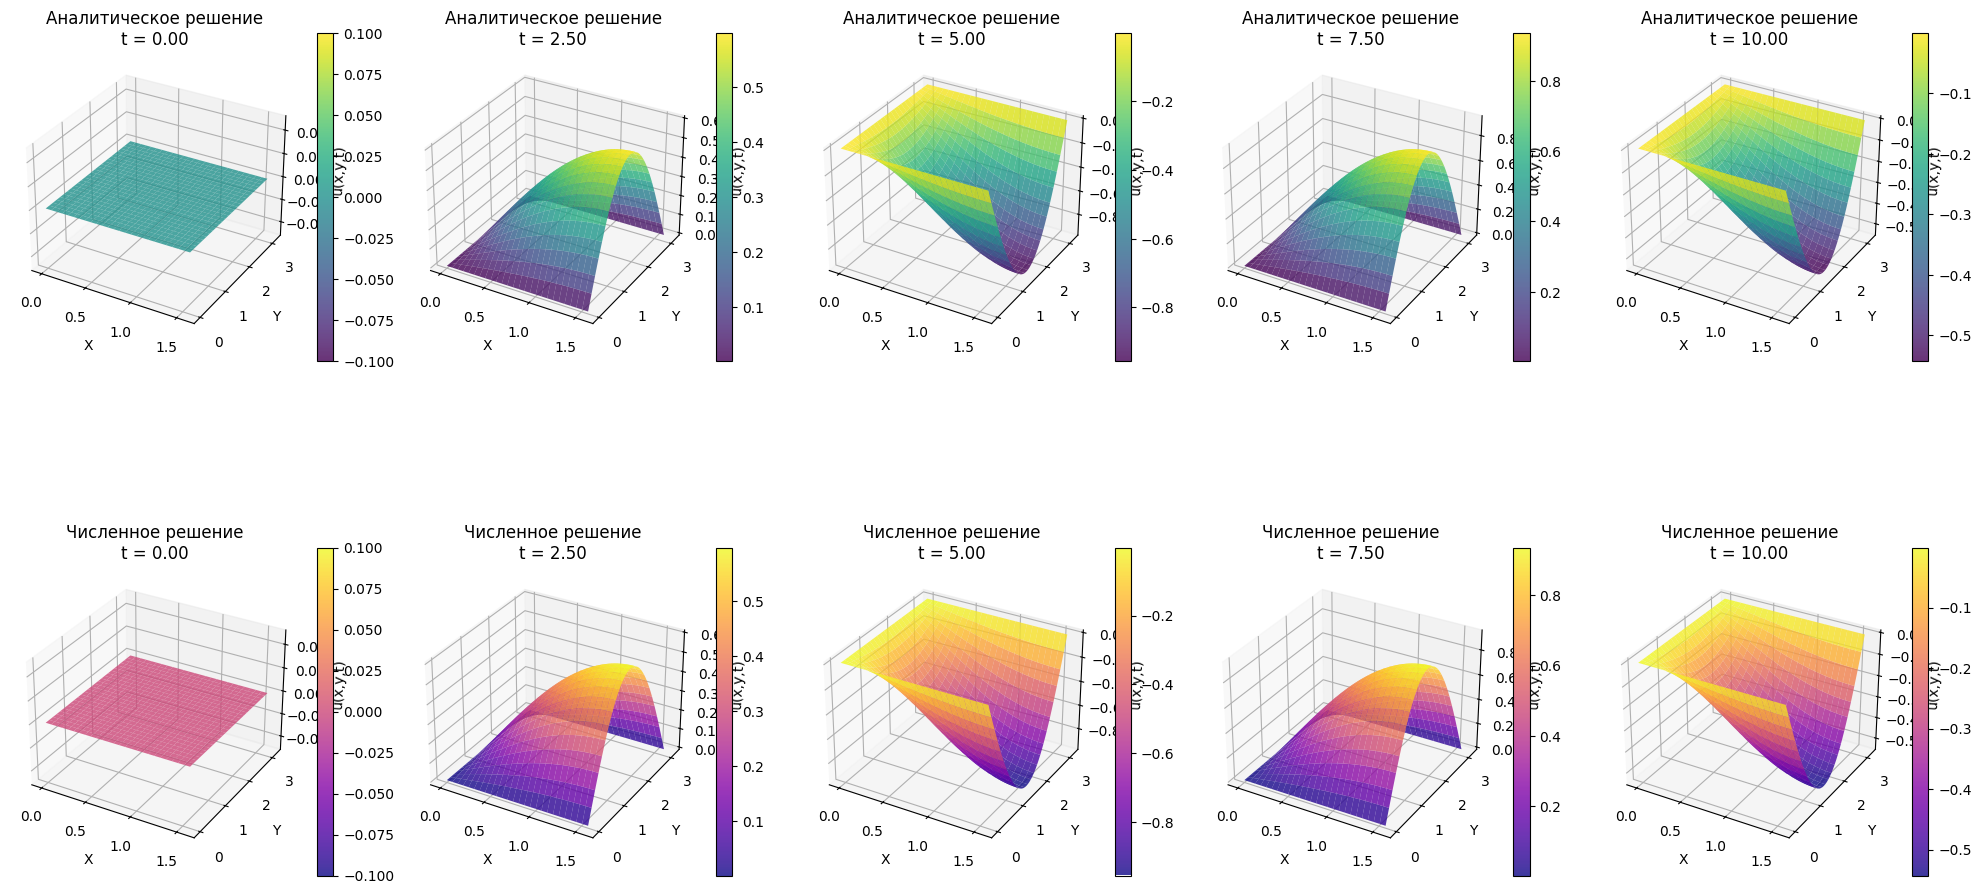

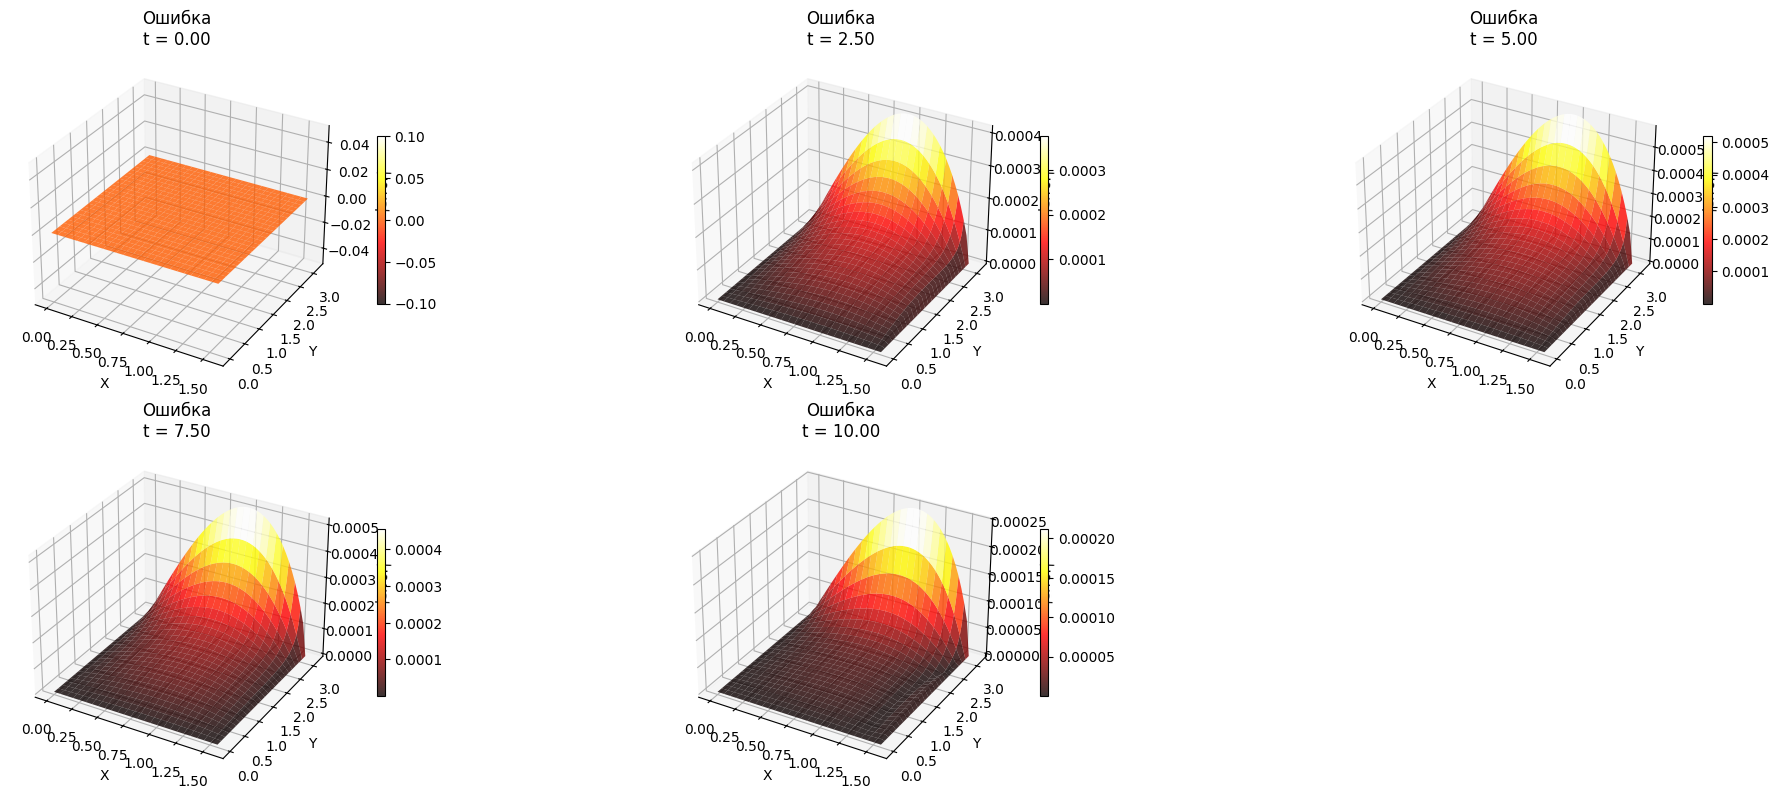

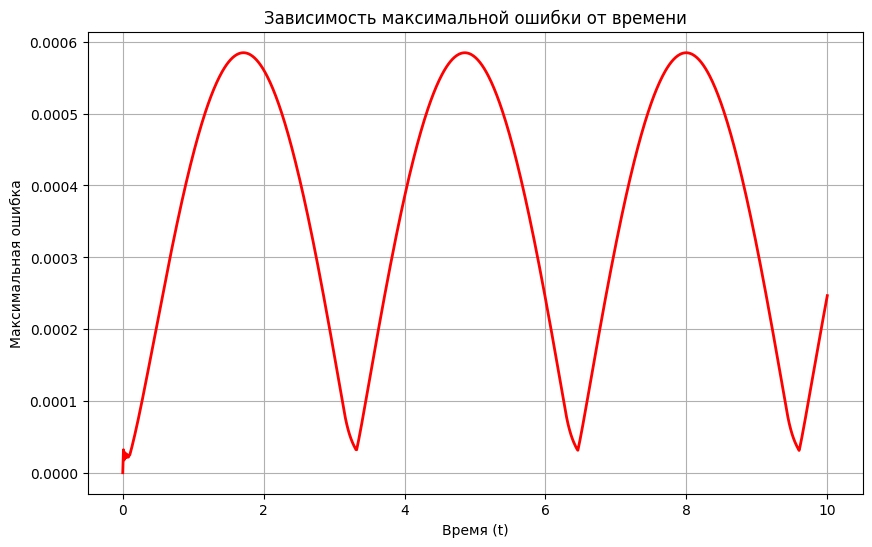

Максимальная ошибка в конечный момент времени: 2.465109e-04
Средняя ошибка в конечный момент времени: 2.465426e-05


In [51]:
Lx_count = 50
Ly_count = 50
T_count = 1000
T2_count = T_count * 2

hx = Lx / Lx_count
hy = Ly / Ly_count
tau = T_max / T_count
tau2 = tau / 2

X = np.linspace(0, Lx, Lx_count + 1)
Y = np.linspace(0, Ly, Ly_count + 1)
T = np.linspace(0, T_max, T2_count + 1)

u_num = solve_alternating_directions()
u_num = u_num[:, :,::2]
T = T[::2]
# Создаем сетку для построения графиков
X_grid, Y_grid = np.meshgrid(X, Y, indexing='ij')

# Выбираем моменты времени для визуализации
time_indices = [0, len(T)//4, len(T)//2, 3*len(T)//4, len(T)-1]
time_labels = [f"t = {T[i]:.2f}" for i in time_indices]

# Создаем фигуру для сравнения решений
fig = plt.figure(figsize=(20, 12))

for idx, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
    # Аналитическое решение
    ax1 = fig.add_subplot(2, 5, idx + 1, projection='3d')
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    surf1 = ax1.plot_surface(X_grid, Y_grid, u_analytical, cmap='viridis', alpha=0.8)
    ax1.set_title(f'Аналитическое решение\n{t_label}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('u(x,y,t)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # Численное решение
    ax2 = fig.add_subplot(2, 5, idx + 6, projection='3d')
    surf2 = ax2.plot_surface(X_grid, Y_grid, u_num[:, :, t_idx], cmap='plasma', alpha=0.8)
    ax2.set_title(f'Численное решение\n{t_label}')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('u(x,y,t)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5)

plt.tight_layout()
plt.show()

# Визуализация ошибки
fig2 = plt.figure(figsize=(20, 8))

for idx, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
    ax = fig2.add_subplot(2, 3, idx + 1, projection='3d')
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    error = np.abs(u_num[:, :, t_idx] - u_analytical)
    surf = ax.plot_surface(X_grid, Y_grid, error, cmap='hot', alpha=0.8)
    ax.set_title(f'Ошибка\n{t_label}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('|error|')
    fig2.colorbar(surf, ax=ax, shrink=0.5)

plt.tight_layout()
plt.show()

# График максимальной ошибки по времени
max_errors = []
for t_idx in range(len(T)):
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    max_error = np.max(np.abs(u_num[:, :, t_idx] - u_analytical))
    max_errors.append(max_error)

plt.figure(figsize=(10, 6))
plt.plot(T, max_errors, 'r-', linewidth=2)
plt.xlabel('Время (t)')
plt.ylabel('Максимальная ошибка')
plt.title('Зависимость максимальной ошибки от времени')
plt.grid(True)
plt.show()

# Вывод статистики по ошибкам
final_error = np.max(np.abs(u_num[:, :, -1] - analytical_solution(X_grid, Y_grid, T[-1])))
print(f"Максимальная ошибка в конечный момент времени: {final_error:.6e}")
print(f"Средняя ошибка в конечный момент времени: {np.mean(np.abs(u_num[:, :, -1] - analytical_solution(X_grid, Y_grid, T[-1]))):.6e}")

In [52]:
def solve_fractional_steps():
    u_num = np.zeros((len(X), len(Y), len(T)))

    for i in range(len(X)):
        for j in range(len(Y)):
            u_num[i, j, 0] = psi(X[i], Y[j])
    
    N = len(X) - 1
    M = len(Y) - 1
    
    for k in range(0, len(T) - 1, 2):
        u_prev = u_num[:, :, k]
        u_next = np.zeros_like(u_prev)
        
        for j in range(len(Y)):
            A = np.zeros(len(X))
            B = np.zeros(len(X))
            C = np.zeros(len(X))
            D = np.zeros(len(X))
            
            for i in range(1, N):
                A[i] = -a_coeff / hx ** 2
                B[i] = 1 / tau + 2 * a_coeff / hx ** 2
                C[i] = -a_coeff / hx ** 2
                D[i] = f(X[i], Y[j], T[k]) / 2 + u_prev[i, j] / tau
            
            coeff1 = (-alpha1 / 2 / hx) / C[1]
            A[0] = 0
            B[0] = (alpha1 * (-3 /(2 * hx)) + beta1) - A[1] * coeff1
            C[0] = (alpha1 * (4 /(2 * hx))) - B[1] * coeff1
            D[0] = gamma1(Y[j], T[k + 1]) - D[1] * coeff1
            
            coeff2 = (alpha2 / 2 / hx) / A[N - 1]
            A[N] = -alpha2 * (4 / (2 * hx)) - B[N - 1] * coeff2
            B[N] = alpha2 * (3 / (2 * hx)) + beta2 - C[N - 1] * coeff2
            C[N] = 0
            D[N] = gamma2(Y[j], T[k + 1]) - D[N - 1] * coeff2
            
            alpha_prop = np.zeros(N + 1)
            beta_prop = np.zeros(N + 1)
            
            if abs(B[0]) < 1e-12:
                raise ValueError("Деление на ноль в методе прогонки")
           
            alpha_prop[0] = -C[0] / B[0]
            beta_prop[0] = D[0] / B[0]

            for i in range(1, N + 1):
                denominator = B[i] + A[i] * alpha_prop[i - 1]
                if abs(denominator) < 1e-12:
                    raise ValueError("Деление на ноль в методе прогонки")
                if i < N:
                    alpha_prop[i] = -C[i] / denominator
                beta_prop[i] = (D[i] - A[i] * beta_prop[i - 1]) / denominator

            u_next[N, j] = beta_prop[N]
            
            for i in range(N - 1, -1, -1):
                u_next[i, j] = alpha_prop[i] * u_next[i + 1, j] + beta_prop[i]
         
        u_num[:, :, k + 1] = u_next
            
        u_prev = u_num[:, :, k + 1]
        u_next = np.zeros_like(u_prev)       
        
        for i in range(len(X)):
            A = np.zeros(len(Y))
            B = np.zeros(len(Y))
            C = np.zeros(len(Y))
            D = np.zeros(len(Y))
            
            for j in range(1, M):
                A[j] = -b_coeff / hy ** 2
                B[j] = 1 / tau + 2 * b_coeff / hy ** 2
                C[j] = -b_coeff / hy ** 2
                D[j] = f(X[i], Y[j], T[k + 2]) / 2 + u_prev[i, j] / tau
                
            coeff3 = (-alpha3 / 2 / hy) / C[1]
            A[0] = 0
            B[0] = (alpha3 * (-3 /(2 * hy)) + beta3) - A[1] * coeff3
            C[0] = (alpha3 * (4 /(2 * hy))) - B[1] * coeff3
            D[0] = gamma3(X[i], T[k + 2]) - D[1] * coeff3
            
            coeff4 = (alpha4 / 2 / hy) / A[M - 1]
            A[M] = -alpha4 * (4 / (2 * hy)) - B[M - 1] * coeff4
            B[M] = alpha4 * (3 / (2 * hy)) + beta4 - C[M - 1] * coeff4
            C[M] = 0
            D[M] = gamma4(X[i], T[k + 2]) - D[M - 1] * coeff4

            alpha_prop = np.zeros(M + 1)
            beta_prop = np.zeros(M + 1)
            
            if abs(B[0]) < 1e-12:
                raise ValueError("Деление на ноль в методе прогонки")
           
            alpha_prop[0] = -C[0] / B[0]
            beta_prop[0] = D[0] / B[0]

            for j in range(1, M + 1):
                denominator = B[j] + A[j] * alpha_prop[j - 1]
                if abs(denominator) < 1e-12:
                    raise ValueError("Деление на ноль в методе прогонки")
                if j < M:
                    alpha_prop[j] = -C[j] / denominator
                beta_prop[j] = (D[j] - A[j] * beta_prop[j - 1]) / denominator

            u_next[i, M] = beta_prop[M]
            
            for j in range(M - 1, -1, -1):
                u_next[i, j] = alpha_prop[j] * u_next[i, j + 1] + beta_prop[j]
            
        u_num[:, :, k + 2] = u_next
        
    return u_num

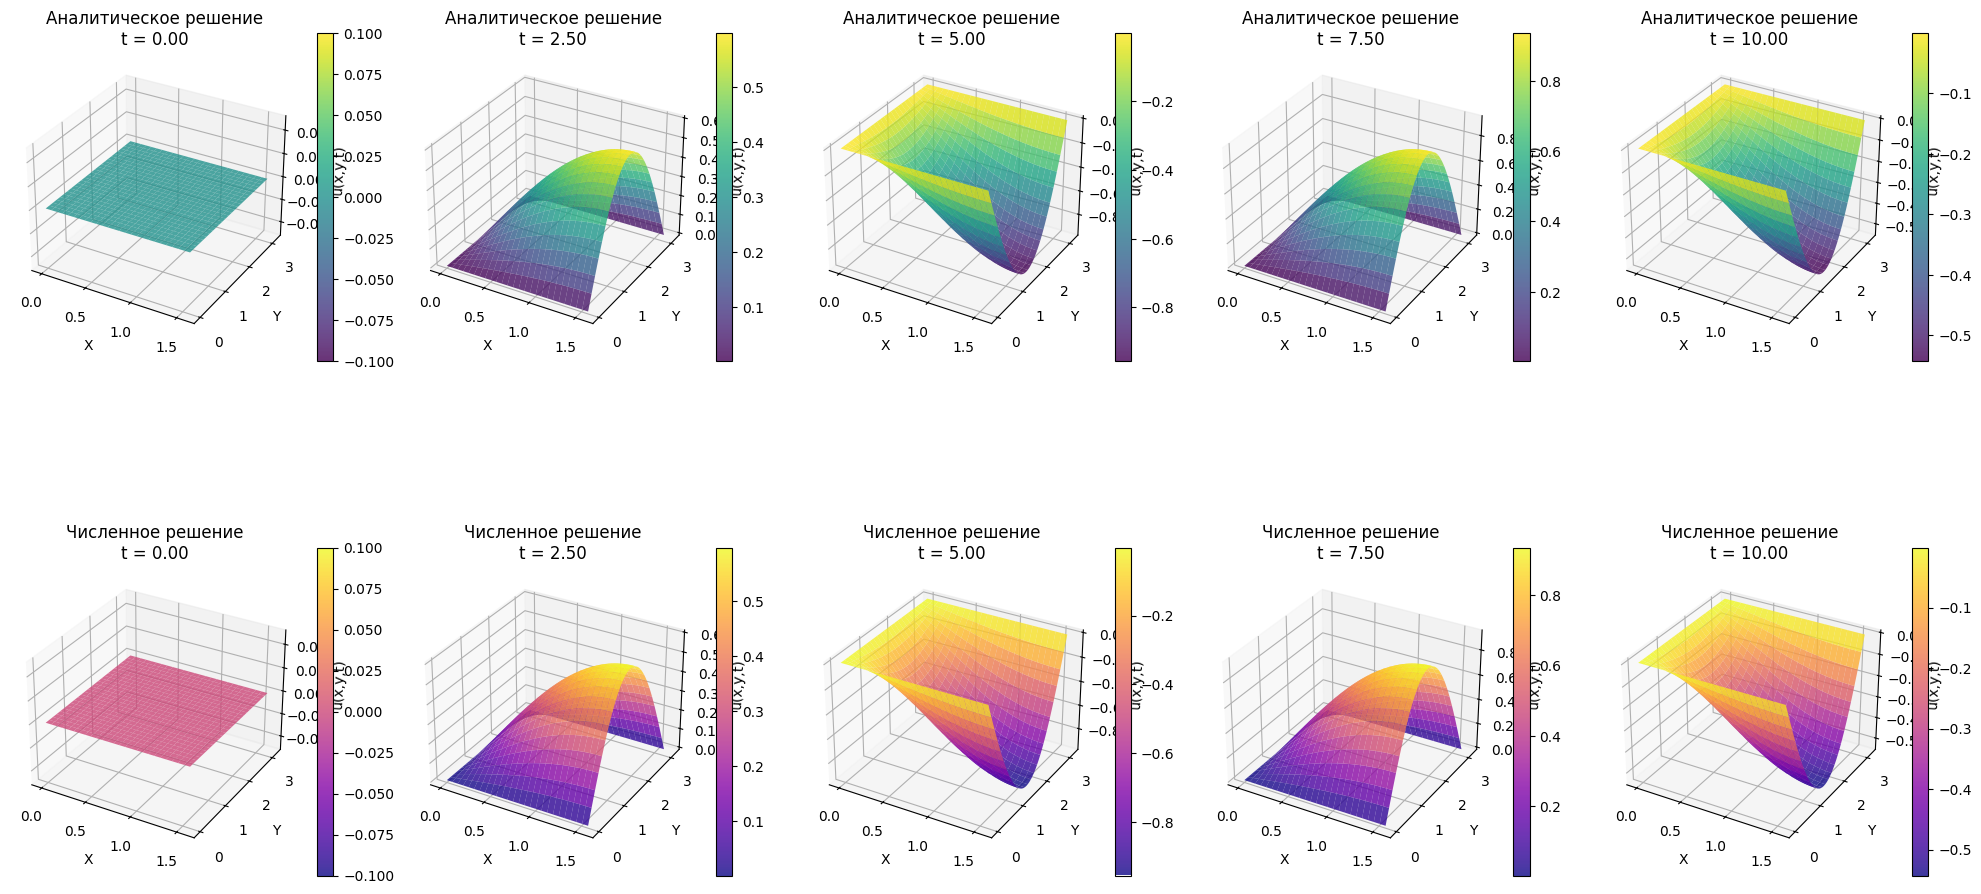

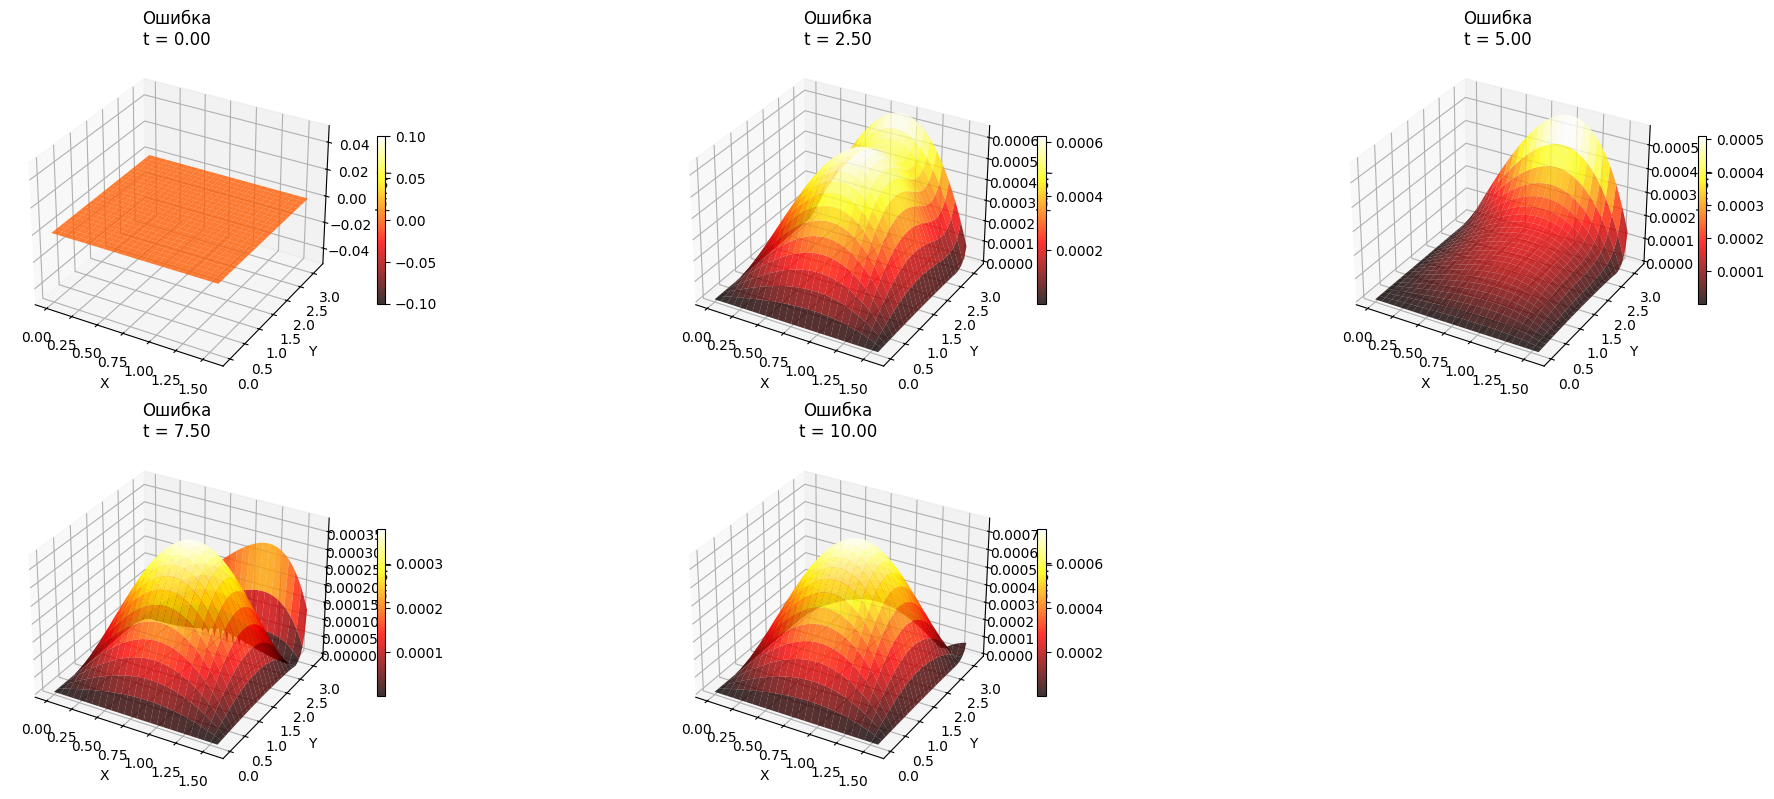

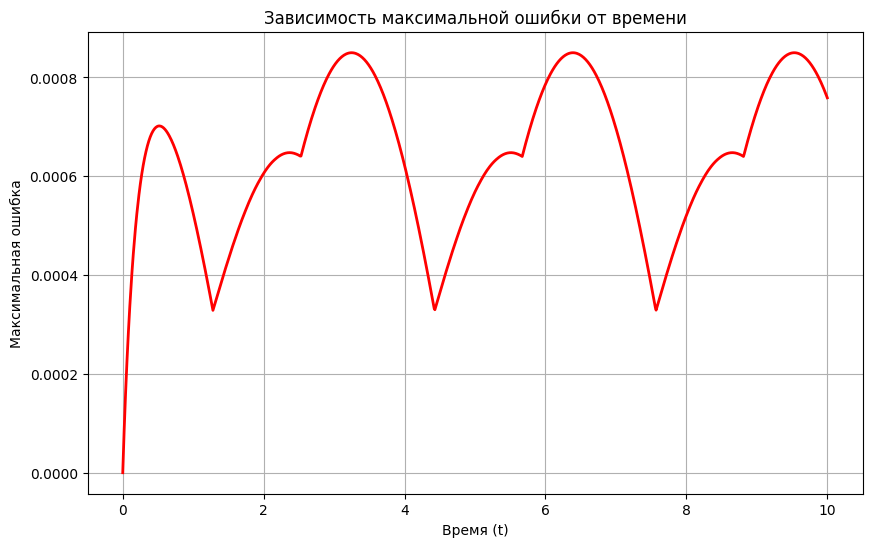

Максимальная ошибка в конечный момент времени: 7.582993e-04
Средняя ошибка в конечный момент времени: 3.175477e-04


In [53]:
Lx_count = 50
Ly_count = 50
T_count = 1000
T2_count = T_count * 2

hx = Lx / Lx_count
hy = Ly / Ly_count
tau = T_max / T_count
tau2 = tau / 2

X = np.linspace(0, Lx, Lx_count + 1)
Y = np.linspace(0, Ly, Ly_count + 1)
T = np.linspace(0, T_max, T2_count + 1)


u_num = solve_fractional_steps()
u_num = u_num[:, :, ::2]
T = T[::2]

# Создаем сетку для построения графиков
X_grid, Y_grid = np.meshgrid(X, Y, indexing='ij')

# Выбираем моменты времени для визуализации
time_indices = [0, len(T)//4, len(T)//2, 3*len(T)//4, len(T)-1]
time_labels = [f"t = {T[i]:.2f}" for i in time_indices]

# Создаем фигуру для сравнения решений
fig = plt.figure(figsize=(20, 12))

for idx, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
    # Аналитическое решение
    ax1 = fig.add_subplot(2, 5, idx + 1, projection='3d')
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    surf1 = ax1.plot_surface(X_grid, Y_grid, u_analytical, cmap='viridis', alpha=0.8)
    ax1.set_title(f'Аналитическое решение\n{t_label}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('u(x,y,t)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # Численное решение
    ax2 = fig.add_subplot(2, 5, idx + 6, projection='3d')
    surf2 = ax2.plot_surface(X_grid, Y_grid, u_num[:, :, t_idx], cmap='plasma', alpha=0.8)
    ax2.set_title(f'Численное решение\n{t_label}')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('u(x,y,t)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5)

plt.tight_layout()
plt.show()

# Визуализация ошибки
fig2 = plt.figure(figsize=(20, 8))

for idx, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
    ax = fig2.add_subplot(2, 3, idx + 1, projection='3d')
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    error = np.abs(u_num[:, :, t_idx] - u_analytical)
    surf = ax.plot_surface(X_grid, Y_grid, error, cmap='hot', alpha=0.8)
    ax.set_title(f'Ошибка\n{t_label}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('|error|')
    fig2.colorbar(surf, ax=ax, shrink=0.5)

plt.tight_layout()
plt.show()


# График максимальной ошибки по времени
max_errors = []
for t_idx in range(len(T)):
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    max_error = np.max(np.abs(u_num[:, :, t_idx] - u_analytical))
    max_errors.append(max_error)

plt.figure(figsize=(10, 6))
plt.plot(T, max_errors, 'r-', linewidth=2)
plt.xlabel('Время (t)')
plt.ylabel('Максимальная ошибка')
plt.title('Зависимость максимальной ошибки от времени')
plt.grid(True)
plt.show()

# Вывод статистики по ошибкам
final_error = np.max(np.abs(u_num[:, :, -1] - analytical_solution(X_grid, Y_grid, T[-1])))
print(f"Максимальная ошибка в конечный момент времени: {final_error:.6e}")
print(f"Средняя ошибка в конечный момент времени: {np.mean(np.abs(u_num[:, :, -1] - analytical_solution(X_grid, Y_grid, T[-1]))):.6e}")

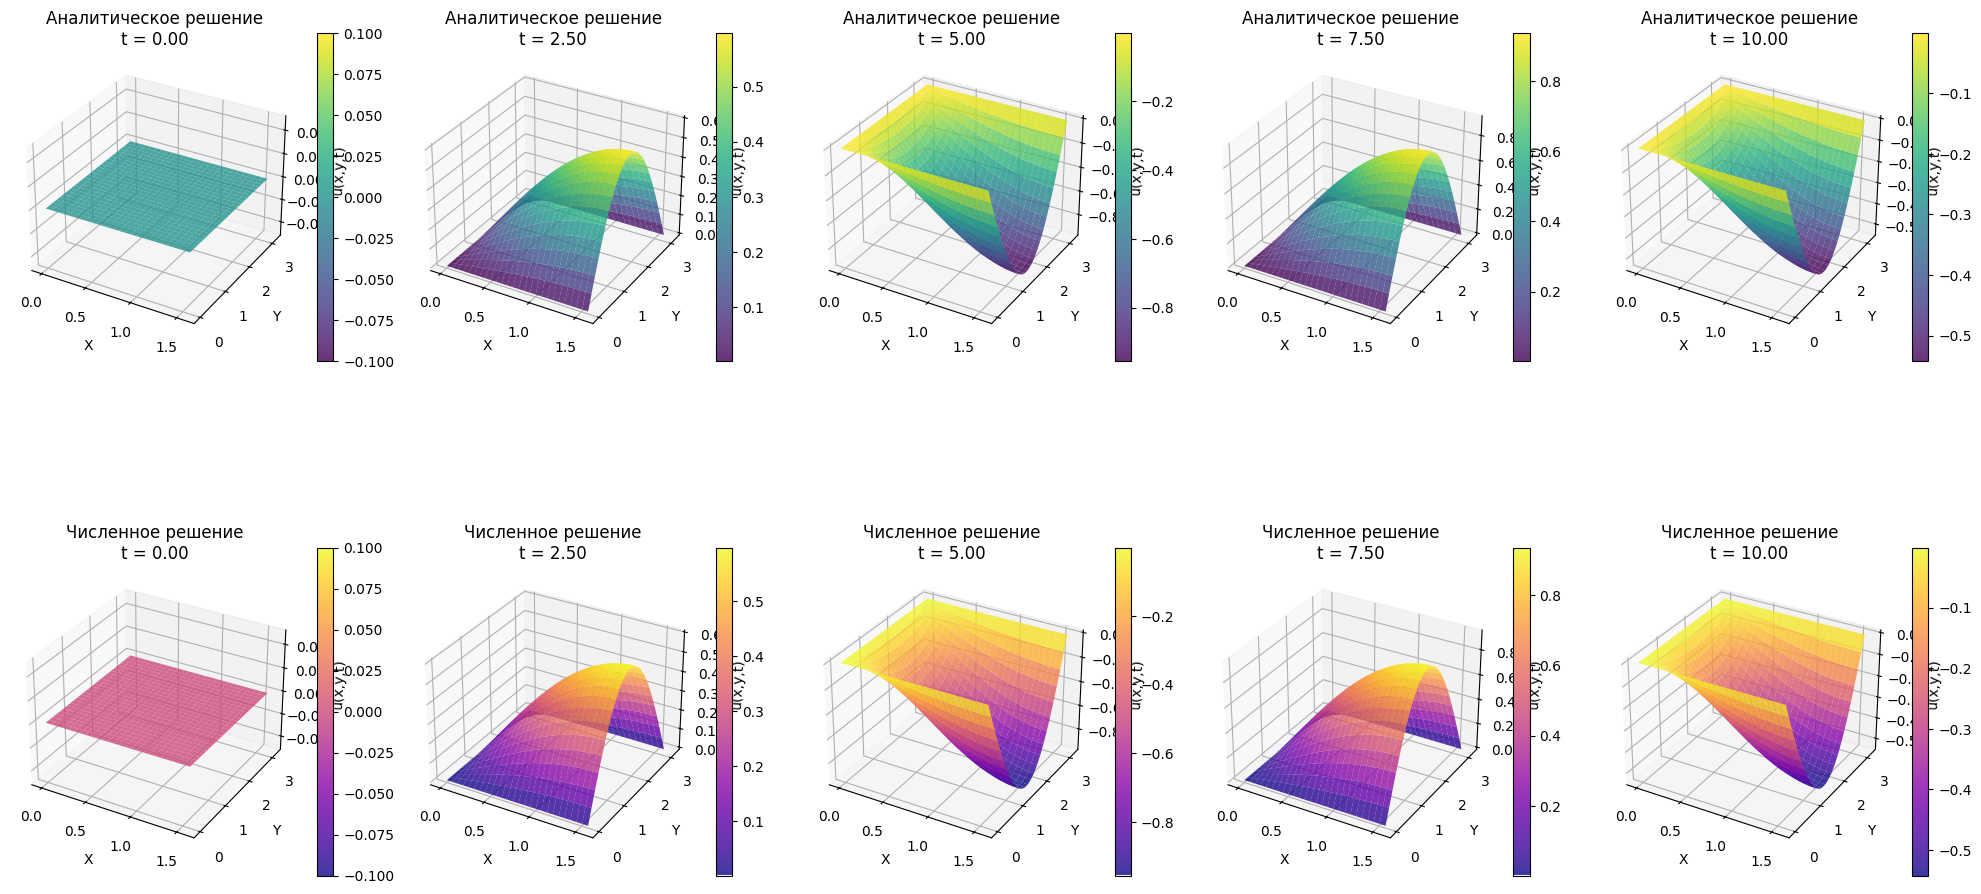

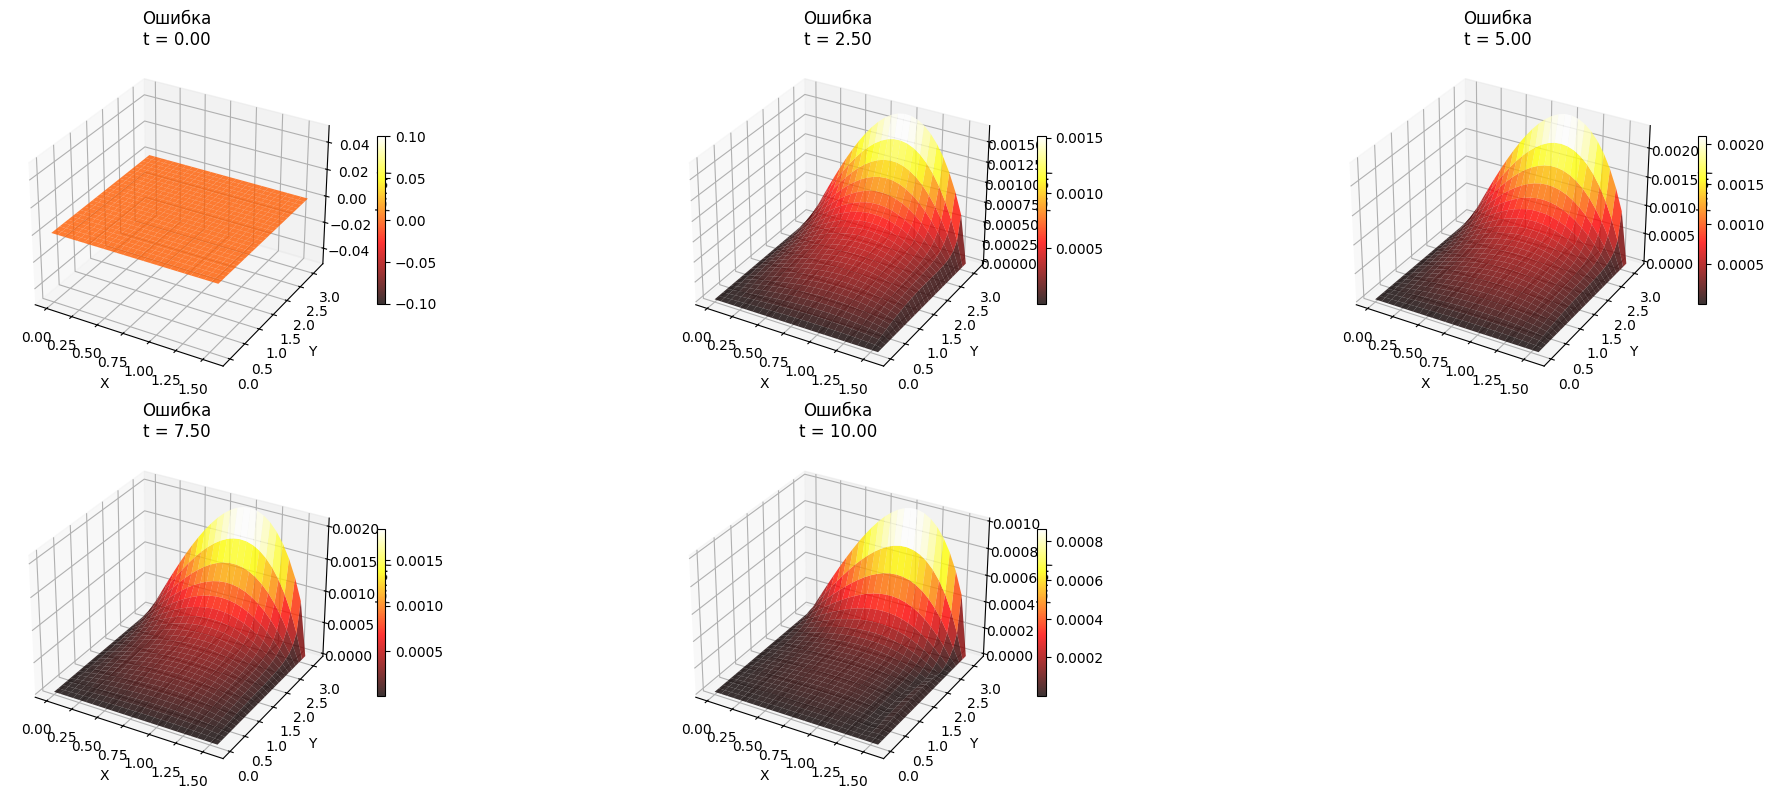

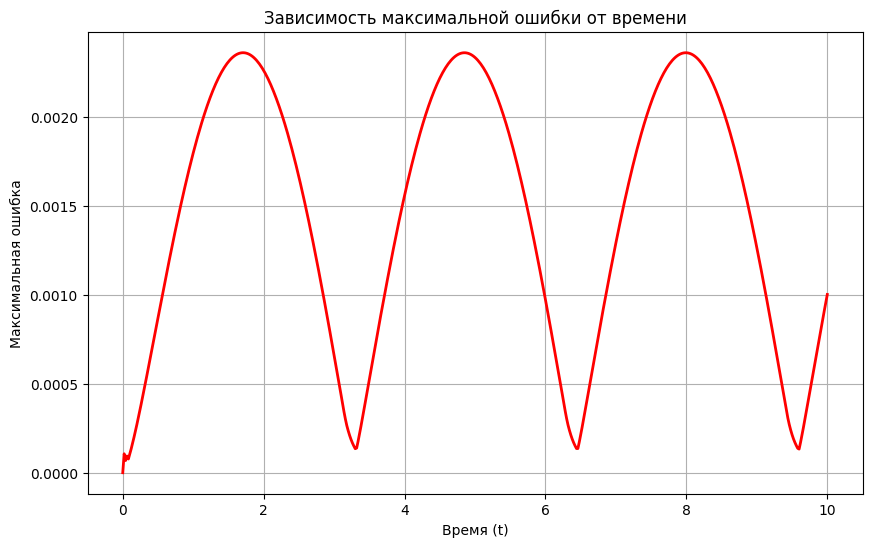

Максимальная ошибка в конечный момент времени: 1.001556e-03
Средняя ошибка в конечный момент времени: 1.031657e-04


In [54]:
Lx_count = 25
Ly_count = 25
T_count = 500
T2_count = T_count * 2

hx = Lx / Lx_count
hy = Ly / Ly_count
tau = T_max / T_count
tau2 = tau / 2

X = np.linspace(0, Lx, Lx_count + 1)
Y = np.linspace(0, Ly, Ly_count + 1)
T = np.linspace(0, T_max, T2_count + 1)

u_num = solve_alternating_directions()
u_num = u_num[:, :,::2]
T = T[::2]
# Создаем сетку для построения графиков
X_grid, Y_grid = np.meshgrid(X, Y, indexing='ij')

# Выбираем моменты времени для визуализации
time_indices = [0, len(T)//4, len(T)//2, 3*len(T)//4, len(T)-1]
time_labels = [f"t = {T[i]:.2f}" for i in time_indices]

# Создаем фигуру для сравнения решений
fig = plt.figure(figsize=(20, 12))

for idx, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
    # Аналитическое решение
    ax1 = fig.add_subplot(2, 5, idx + 1, projection='3d')
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    surf1 = ax1.plot_surface(X_grid, Y_grid, u_analytical, cmap='viridis', alpha=0.8)
    ax1.set_title(f'Аналитическое решение\n{t_label}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('u(x,y,t)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # Численное решение
    ax2 = fig.add_subplot(2, 5, idx + 6, projection='3d')
    surf2 = ax2.plot_surface(X_grid, Y_grid, u_num[:, :, t_idx], cmap='plasma', alpha=0.8)
    ax2.set_title(f'Численное решение\n{t_label}')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('u(x,y,t)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5)

plt.tight_layout()
plt.show()

# Визуализация ошибки
fig2 = plt.figure(figsize=(20, 8))

for idx, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
    ax = fig2.add_subplot(2, 3, idx + 1, projection='3d')
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    error = np.abs(u_num[:, :, t_idx] - u_analytical)
    surf = ax.plot_surface(X_grid, Y_grid, error, cmap='hot', alpha=0.8)
    ax.set_title(f'Ошибка\n{t_label}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('|error|')
    fig2.colorbar(surf, ax=ax, shrink=0.5)

plt.tight_layout()
plt.show()

# График максимальной ошибки по времени
max_errors = []
for t_idx in range(len(T)):
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    max_error = np.max(np.abs(u_num[:, :, t_idx] - u_analytical))
    max_errors.append(max_error)

plt.figure(figsize=(10, 6))
plt.plot(T, max_errors, 'r-', linewidth=2)
plt.xlabel('Время (t)')
plt.ylabel('Максимальная ошибка')
plt.title('Зависимость максимальной ошибки от времени')
plt.grid(True)
plt.show()

# Вывод статистики по ошибкам
final_error = np.max(np.abs(u_num[:, :, -1] - analytical_solution(X_grid, Y_grid, T[-1])))
print(f"Максимальная ошибка в конечный момент времени: {final_error:.6e}")
print(f"Средняя ошибка в конечный момент времени: {np.mean(np.abs(u_num[:, :, -1] - analytical_solution(X_grid, Y_grid, T[-1]))):.6e}")

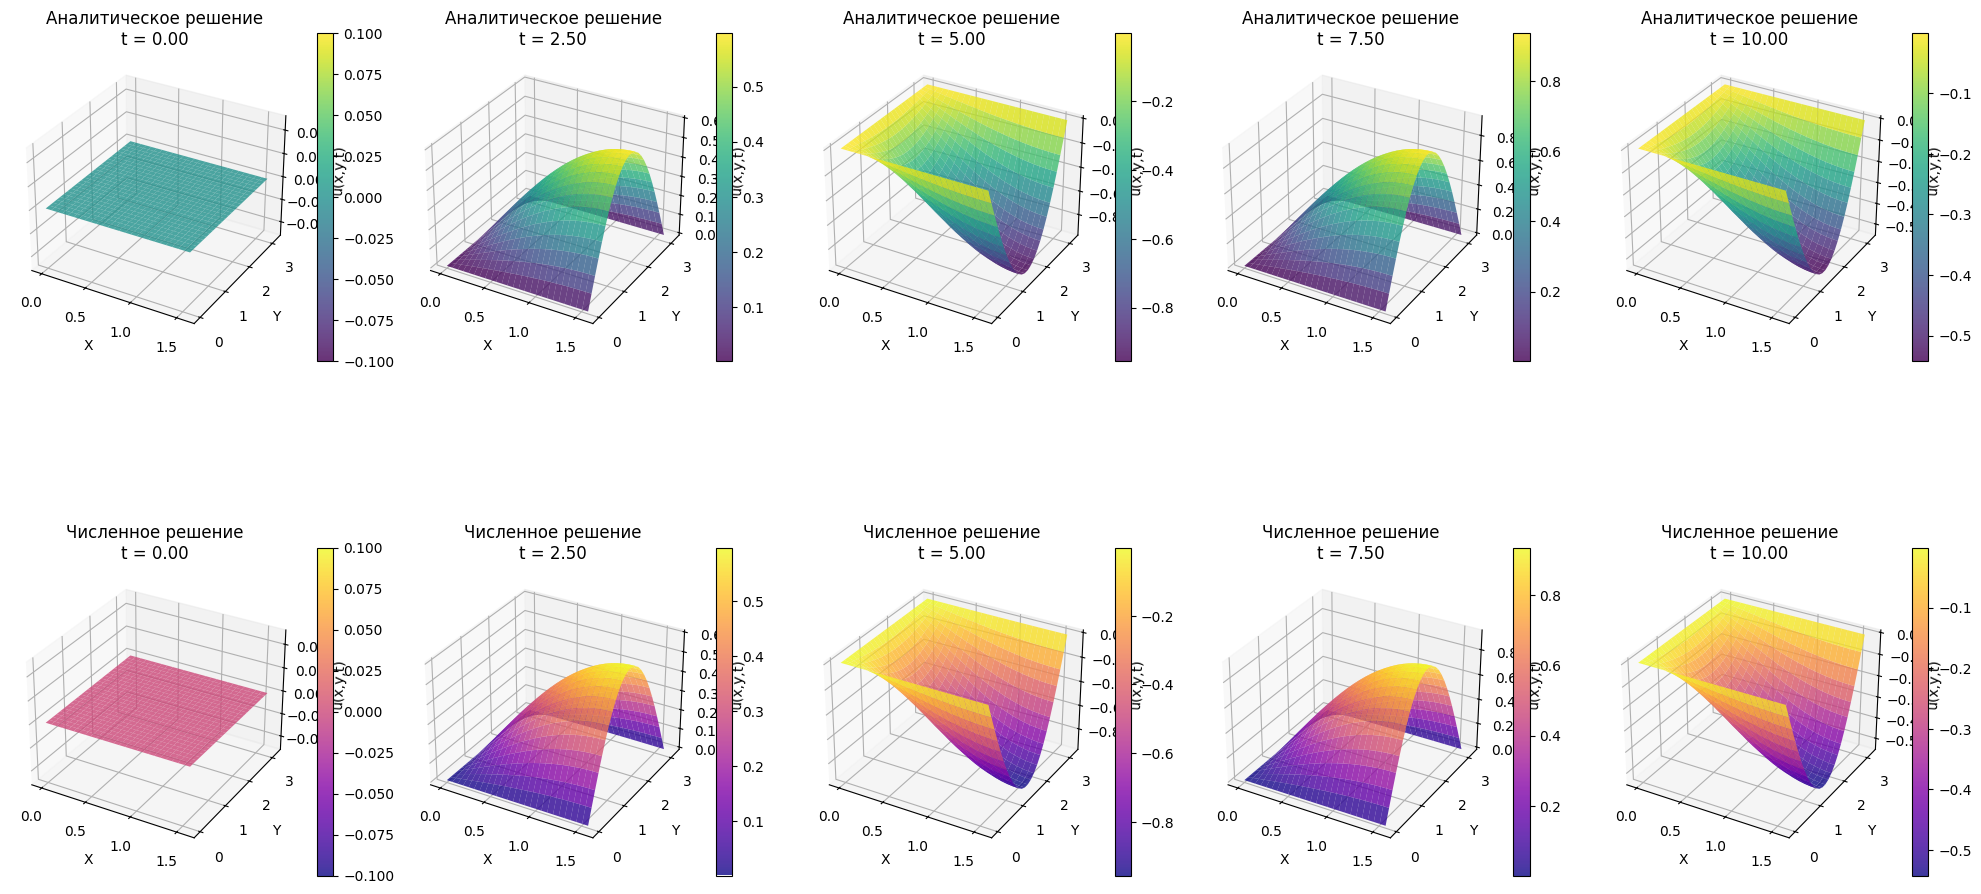

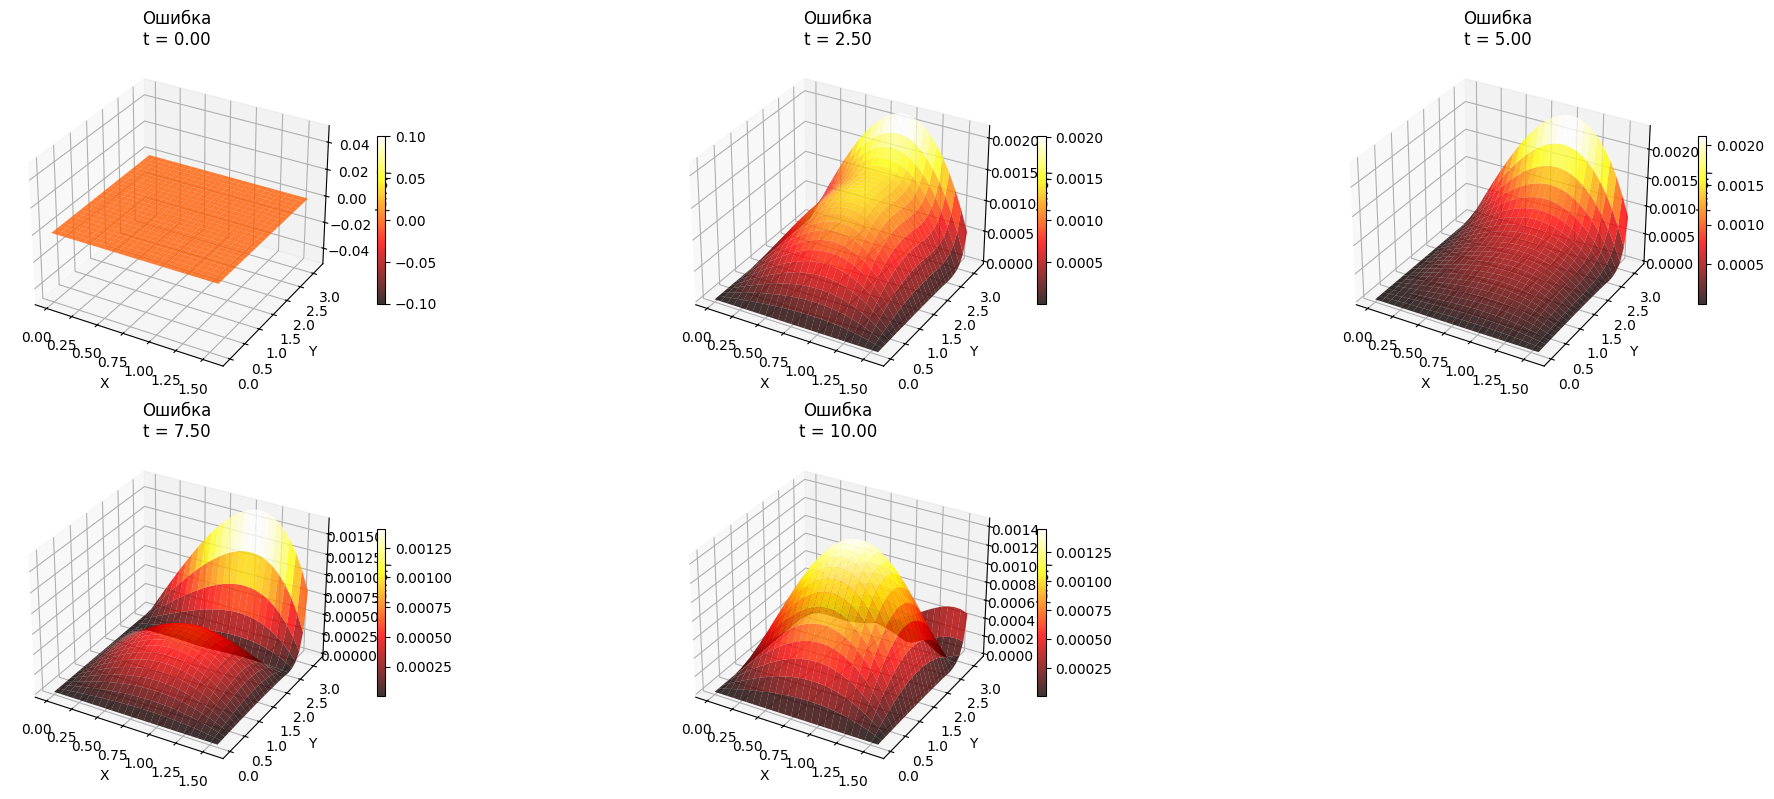

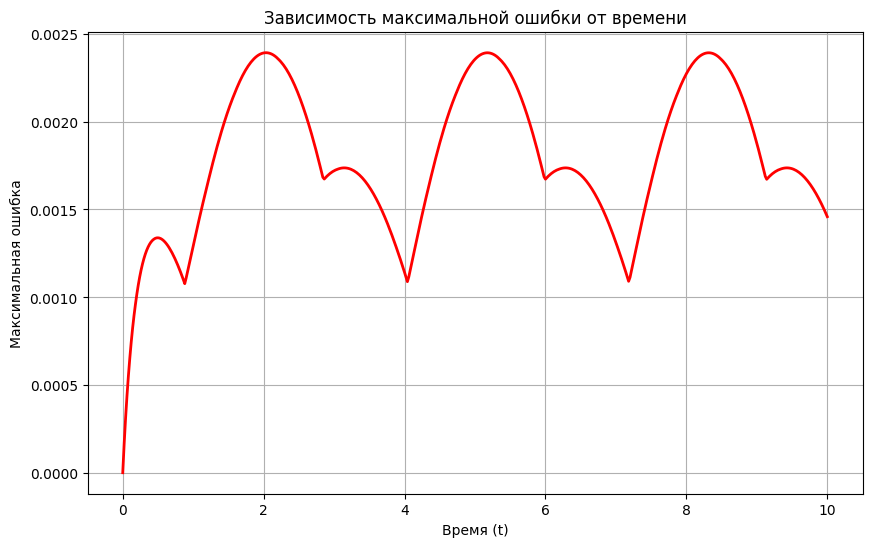

Максимальная ошибка в конечный момент времени: 1.458656e-03
Средняя ошибка в конечный момент времени: 5.636933e-04


In [55]:
Lx_count = 25
Ly_count = 25
T_count = 500
T2_count = T_count * 2

hx = Lx / Lx_count
hy = Ly / Ly_count
tau = T_max / T_count
tau2 = tau / 2

X = np.linspace(0, Lx, Lx_count + 1)
Y = np.linspace(0, Ly, Ly_count + 1)
T = np.linspace(0, T_max, T2_count + 1)


u_num = solve_fractional_steps()
u_num = u_num[:, :, ::2]
T = T[::2]

# Создаем сетку для построения графиков
X_grid, Y_grid = np.meshgrid(X, Y, indexing='ij')

# Выбираем моменты времени для визуализации
time_indices = [0, len(T)//4, len(T)//2, 3*len(T)//4, len(T)-1]
time_labels = [f"t = {T[i]:.2f}" for i in time_indices]

# Создаем фигуру для сравнения решений
fig = plt.figure(figsize=(20, 12))

for idx, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
    # Аналитическое решение
    ax1 = fig.add_subplot(2, 5, idx + 1, projection='3d')
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    surf1 = ax1.plot_surface(X_grid, Y_grid, u_analytical, cmap='viridis', alpha=0.8)
    ax1.set_title(f'Аналитическое решение\n{t_label}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('u(x,y,t)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # Численное решение
    ax2 = fig.add_subplot(2, 5, idx + 6, projection='3d')
    surf2 = ax2.plot_surface(X_grid, Y_grid, u_num[:, :, t_idx], cmap='plasma', alpha=0.8)
    ax2.set_title(f'Численное решение\n{t_label}')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('u(x,y,t)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5)

plt.tight_layout()
plt.show()

# Визуализация ошибки
fig2 = plt.figure(figsize=(20, 8))

for idx, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
    ax = fig2.add_subplot(2, 3, idx + 1, projection='3d')
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    error = np.abs(u_num[:, :, t_idx] - u_analytical)
    surf = ax.plot_surface(X_grid, Y_grid, error, cmap='hot', alpha=0.8)
    ax.set_title(f'Ошибка\n{t_label}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('|error|')
    fig2.colorbar(surf, ax=ax, shrink=0.5)

plt.tight_layout()
plt.show()


# График максимальной ошибки по времени
max_errors = []
for t_idx in range(len(T)):
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    max_error = np.max(np.abs(u_num[:, :, t_idx] - u_analytical))
    max_errors.append(max_error)

plt.figure(figsize=(10, 6))
plt.plot(T, max_errors, 'r-', linewidth=2)
plt.xlabel('Время (t)')
plt.ylabel('Максимальная ошибка')
plt.title('Зависимость максимальной ошибки от времени')
plt.grid(True)
plt.show()

# Вывод статистики по ошибкам
final_error = np.max(np.abs(u_num[:, :, -1] - analytical_solution(X_grid, Y_grid, T[-1])))
print(f"Максимальная ошибка в конечный момент времени: {final_error:.6e}")
print(f"Средняя ошибка в конечный момент времени: {np.mean(np.abs(u_num[:, :, -1] - analytical_solution(X_grid, Y_grid, T[-1]))):.6e}")